In [1]:
from keras.datasets import mnist
from keras.utils import np_utils
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.optimizers import Adam, RMSprop
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm_notebook

# Dataset of 60,000 28x28 grayscale images of the 10 digits, along with a test set of 10,000 images.
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

Using TensorFlow backend.


11493376/11490434 [==============================] - 1s 0us/step


In [2]:
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

z_dim = 100

adam = Adam(lr=0.0002, beta_1=0.5)

g = Sequential()
g.add(Dense(256, input_dim=z_dim, activation=LeakyReLU(alpha=0.2)))
g.add(Dense(512, activation=LeakyReLU(alpha=0.2)))
g.add(Dense(784, activation='sigmoid'))  # Values between 0 and 1
g.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

d = Sequential()
d.add(Dense(256, input_dim=784, activation=LeakyReLU(alpha=0.2)))
d.add(Dropout(0.3))
d.add(Dense(64, activation=LeakyReLU(alpha=0.2)))
d.add(Dropout(0.3))
d.add(Dense(1, activation='sigmoid'))  # Values between 0 and 1
d.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

d.trainable = False
input_raw_data = Input((z_dim,))
hidden = g(input_raw_data)
output = d(hidden)

gan = Model(input_raw_data,output)

gan.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

/usr/local/lib/python3.6/dist-packages/keras/activations.py:235: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


In [0]:
def plot_loss(losses):

  g_loss = [v[0] for v in losses["G"]]

  d_loss = [v[0] for v in losses["D"]]

  plt.figure(figsize=(10,8))

  plt.plot(d_loss, label="Discriminator loss")
  plt.plot(g_loss, label="Generator loss")
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()


def plot_generated(n_ex = 10, dim = (1,10)):

  noise = np.random.normal(0,1,(n_ex,z_dim))

  generated_images = g.predict(noise)

  generated_images = generated_images.reshape(n_ex,28,28)

  plt.figure(figsize = (12,2))

  for i in range(n_ex):

    plt.subplot(dim[0],dim[1],i+1)

    plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')

    plt.axis('off')

  plt.tight_layout()
  
  plt.show()


In [0]:
losses = {'D' : [],'G' : []}

def train(epochs = 10,batch_size = 128,n_freq = 20):

    batchCount = int(X_train.shape[0] / batch_size)
    
    print('Epochs:', epochs)
    
    print('Batch size:', batch_size)
    
    print('Batches per epoch:', batchCount)

    for e in tqdm_notebook(range(1, epochs+1)):

      d_loss = 0

      g_loss = 0

      for _ in range(batchCount):

        img_batch = X_train[np.random.randint(0,X_train.shape[0],batch_size)]

        noise = np.random.normal(0,1,(batch_size,z_dim))

        y_labels = np.zeros(2*batch_size)

        generated_images = g.predict(noise)

        y_labels[:batch_size] = 0.9

        X = np.concatenate((img_batch,generated_images))

        d.trainable = True

        d_loss = d.train_on_batch(X,y_labels)

        noise = np.random.normal(0,1,(batch_size,z_dim))

        fake_labels = np.ones(batch_size)

        d.trainable = False

        g_loss = gan.train_on_batch(noise,fake_labels)

      losses['D'].append(d_loss)

      losses['G'].append(g_loss)

      if e == 1 or int(e) % int(n_freq) == 0:
        
        plot_generated()


    plot_loss(losses)

Epochs: 100
Batch size: 128
Batches per epoch: 468


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


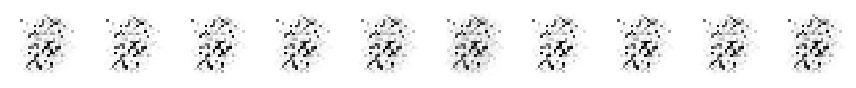

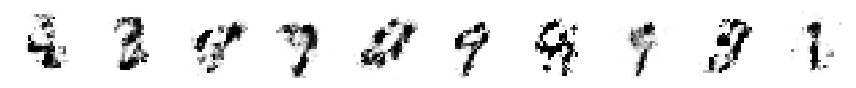

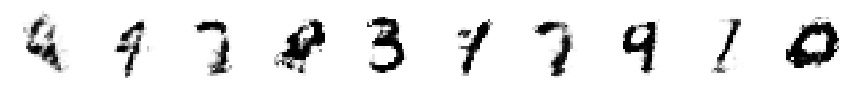

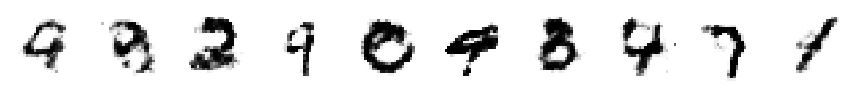

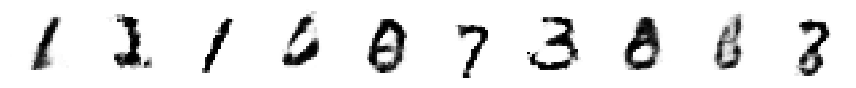

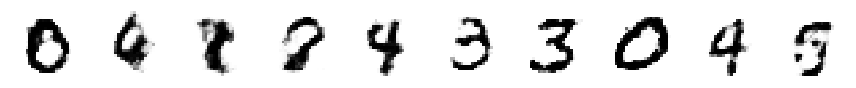

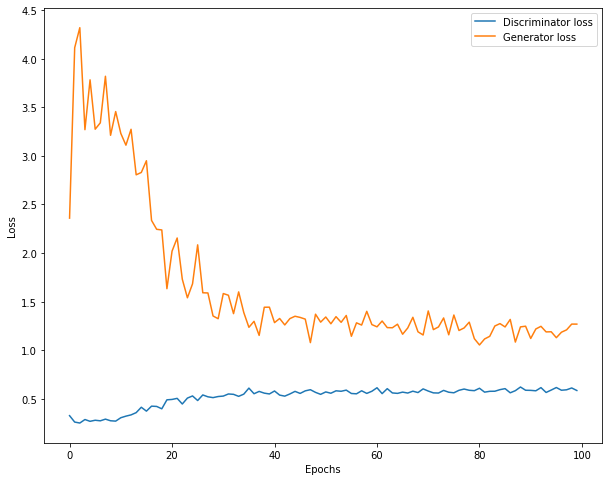

In [5]:
train(epochs = 100,batch_size = 128,n_freq = 20)